# Heuristic (Geometric) Analysis F1 Score Generator

Author: Abid Mahdi, University of Southampton. 28/03/2022. am14g19@soton.ac.uk.

This notebook tests how good a heuristic analysis model is by generating an F1 score for a dataset of squats. 

Input: tuples of the squat videos and trained frame analysis models.

## TOC:
0. [Import Libraries & Setup](#0.-Import-Libraries-&-Setup)
1. [Setup Training & Testing Sets](#1.-Setup-Training-&-Testing-Sets)
2. [Evaluation](#2.-Evaluation)

# 0. Import Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp

import math

import os
import pickle

from joblib import load

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Get the angle between 3 keypoint's coordinates
# INPUT: frame (dictonary storing the coordinates of all the keypoints), the keypoint numbers
# OUTPUT: angle as float
def get_angle(frame, keypoint_1, keypoint_2, keypoint_3):
    a = np.array([frame['x'+str(keypoint_1)], frame['y'+str(keypoint_1)]]) # First
    b = np.array([frame['x'+str(keypoint_2)], frame['y'+str(keypoint_2)]]) # Mid
    c = np.array([frame['x'+str(keypoint_3)], frame['y'+str(keypoint_3)]]) # End
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = math.degrees(np.arccos(cosine_angle))
    
    if angle > 180.0:
        angle = 360 - angle
        
    return angle

In [3]:
all_videos = pickle.load(open('all-squats.dump', 'rb'))

In [4]:
len(all_videos)

90

# 1. Setup Training & Testing Sets

In [5]:
X = []
y = []

for i in all_videos:
    X.append(i[1])
    y.append(i[0])

In [6]:
_, X_test, _, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X_test), len(y_test))

30 30


The test set corresponds to the training set generated in the video-to-frames notebook used to find trends in the data.

In [7]:
y_test # A list of the labels

['leaning',
 'good',
 'leaning',
 'parallel',
 'good',
 'good',
 'leaning',
 'parallel',
 'good',
 'leaning',
 'parallel',
 'leaning',
 'leaning',
 'parallel',
 'good',
 'good',
 'good',
 'good',
 'leaning',
 'leaning',
 'parallel',
 'parallel',
 'parallel',
 'good',
 'leaning',
 'good',
 'parallel',
 'parallel',
 'good',
 'parallel']

# 2. Evaluation

In [8]:
labels= ['good', 'leaning', 'parallel']

def evaluate_model(model_name, prediction, display_matrix=False):
    acc = metrics.accuracy_score(y_test, prediction)
    f1 = f1_score(y_test, prediction, average='micro')
    precision = precision_score(y_test, prediction, average='macro')
    recall = recall_score(y_test, prediction, average='macro')

    model_metrics = {'Classifier': model_name, 
                     'Accuracy': acc, 
                     'Precision': precision, 
                     'Recall': recall,
                     'F1 Score': f1}

    if display_matrix:
        cm = confusion_matrix(y_test, prediction, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.title(model_name)
        plt.show()

    return model_metrics

In [9]:
# Function to search through all the frames in the video and label whole video
# INPUT: list of frames with the coordinates of the keypoints (landmarks) in each frame and the trained model
# OUTPUT: string of the label outputted by the trained model
def label_video(frames):
    # By default, the video is labelled as good until a frame with a mistake is found
    label = 'parallel'
    
    for f in frames:
        # If a frame with a mistake is found
        if round(f['coordinates']['y'+str(23)], 2) == round(f['coordinates']['y'+str(25)], 2):
            label = 'good'
        elif get_angle(f['coordinates'], 11, 23, 25) < 35:
            return 'leaning'
        
    return label

The if statements are based on the data visualisation.

In [10]:
y_pred = []

# Make predictions and populate y_pred
for video in X_test:
    y_pred.append(label_video(video))

In [11]:
y_pred

['leaning',
 'good',
 'leaning',
 'parallel',
 'leaning',
 'parallel',
 'leaning',
 'parallel',
 'parallel',
 'leaning',
 'parallel',
 'leaning',
 'leaning',
 'parallel',
 'parallel',
 'good',
 'parallel',
 'good',
 'leaning',
 'leaning',
 'parallel',
 'parallel',
 'parallel',
 'parallel',
 'leaning',
 'good',
 'parallel',
 'parallel',
 'good',
 'parallel']

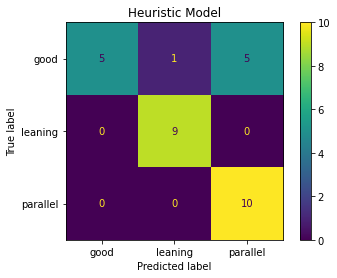

{'Classifier': 'Heuristic Model',
 'Accuracy': 0.8,
 'Precision': 0.8555555555555555,
 'Recall': 0.8181818181818182,
 'F1 Score': 0.8000000000000002}

In [12]:
evaluate_model('Heuristic Model', y_pred, True)

The model does ok, but it looks like there is some confusion in labelling good squats.

In [13]:
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

        good       1.00      0.45      0.62        11
     leaning       0.90      1.00      0.95         9
    parallel       0.67      1.00      0.80        10

    accuracy                           0.80        30
   macro avg       0.86      0.82      0.79        30
weighted avg       0.86      0.80      0.78        30

